# TP5 - Équations différentielles ordinaires : Étude d’un modèlephénoménologique d’un tremblement de terre

In [1]:
from matplotlib import pyplot as plt
from time import time
from scipy import integrate as inte
import numpy as np

## 5.1 Frottement fluide

### A - resolution analytique

On ecrit une fonction qui nous donne la solution analytique en fonction des parametres du problemes pour verifier nos resolution numerique.

In [2]:
def solution_analytique(t, params):
    w = np.sqrt(params["w0"]**2 - 1/(4*params["tau"]**2))
    A = params["x0"] - params["v0"]/(params["tau"]*params["w0"]**2) #x(t0) = x0
    B = (A/(2*params["tau"]) - params["v0"])/w #v(t0) = x_point0
    return np.exp(-t/(2*params["tau"])) * \
        (A*np.cos(w*t) + B*np.sin(w*t)) + \
        params["v0"]*(t + 1/(params["tau"]*params["w0"]**2))

On peut maintenant tracer l'evolution de la position de la masse avec les donnés du probleme.

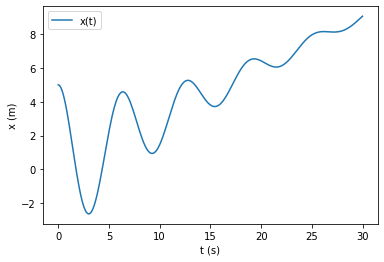

In [3]:
params = {
    "x0": 5,
    "tau": 5,
    "w0": 1,
    "v0" : 0.3
}

t_list = np.linspace(0, 30, 250)

plt.plot(t_list, solution_analytique(t_list, params), label="x(t)")
plt.xlabel("t (s)")
plt.ylabel("x (m)")
plt.legend()
plt.show()

On observe des oscilations descroissante autour d'une pente de coeficient dirrecteur v0.

### B - Methode de Runge Kutta

On doit ecrire la fonction "dxidt" qui calcule la dérivé de notre solutions.

Les $x_i$  sont ici des vecteur contenant ($ \dot{x} $, x) de maniere à ce que la derivé des xi contienne ($ \ddot{x} $, $ \dot{x} $) ce qui nous permet d'ecrire l'equation differentiel du mouvement.

In [4]:
def dxidt(t, X, params):
    x, x_point = X[0], X[1]
    # On caclule la derivé du vecteur X
    x_point_point = -params["w0"]**2 * (x - params["v0"] * t) - \
        x_point / params["tau"]
    
    return np.array([x_point, x_point_point])

On peut maintenant utiliser les fonction données pour resoudre numeriquement. On en ecrira des version qui retourne une liste de $x_i$ à partir d'une liste d'instant t.

In [5]:
def rk2(dxidt, t0, xi0, dt, params ):
    # Applique la formule de Runge Kutta pour trouver la valeur suivante de xi
    k1 = dt * dxidt (t0, xi0, params = params )
    k2 = dt * dxidt (t0 + 0.5 * dt, xi0 + 0.5 * k1, params = params )
    # mise à jour de la valeur suivante de xi
    xi = xi0 + k2
    return xi

def rk4(dxidt, t0, xi0, dt, params ):
    # Applique la formule de Runge Kutta pour trouver la valeur suivante de xi
    k1 = dt * dxidt (t0, xi0, params = params )
    k2 = dt * dxidt (t0 + 0.5 * dt, xi0 + 0.5 * k1, params = params )
    k3 = dt * dxidt (t0 + 0.5 * dt, xi0 + 0.5 * k2, params = params )
    k4 = dt * dxidt (t0 + dt, xi0 + k3, params = params )
    # mise à jour de la valeur suivante de xi
    xi = xi0 + (1.0 / 6.0) * ( k1 + 2 * k2 + 2 * k3 + k4)
    return xi

In [6]:
def solution_complete(solver, dxidt, T, params):
    solu = np.zeros((len(T), 2))
    solu[0] = [params["x0"], 0]
    for i in range(1, len(T)):
        dt = T[i] - T[i - 1]
        solu[i] = solver(dxidt, T[i - 1], solu[i - 1], dt, params)
        
    return solu

On peut maintenant superposer la solutions analytique aux solutions trouvées avec les methodes rk2 et rk4.

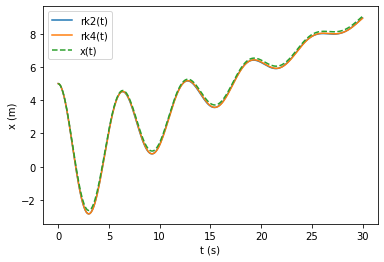

In [7]:
plt.plot(t_list, solution_complete(rk2, dxidt, t_list, params)[:,0], label="rk2(t)")
plt.plot(t_list, solution_complete(rk4, dxidt, t_list, params)[:,0], label="rk4(t)")
plt.plot(t_list, solution_analytique(t_list, params), "--", label="x(t)")

plt.xlabel("t (s)")
plt.ylabel("x (m)")
plt.legend()
plt.show()

On peut voir que les deux solution sont extremement proches, mais que l'on peut tout de même distinguer l'ecart à la solution analytique.

### C - Etude de la convergence numérique

On peut maintenant tracer l'erreur quadratique en fonction de t pour different pas (ou taille de vecteur T).

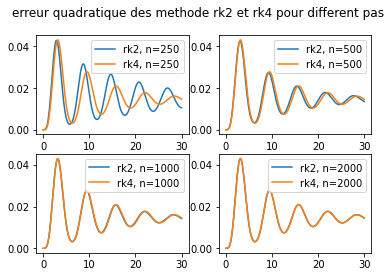

In [8]:
plt.suptitle("erreur quadratique des methode rk2 et rk4 pour different pas")

err_avg_rk2 = []
err_avg_rk4 = []

steps = np.array([250, 500, 1000, 2000])
for window, pas in enumerate(steps):
    t_list = np.linspace(0, 30, pas)
    solu_rk2 = solution_complete(rk2, dxidt, t_list, params)[:,0]
    solu_rk4 = solution_complete(rk4, dxidt, t_list, params)[:,0]
    solu_analityque = solution_analytique(t_list, params)
    
    err_rk2 = (solu_analityque - solu_rk2)**2
    err_rk4 = (solu_analityque - solu_rk4)**2
    
    err_avg_rk2.append(np.mean(err_rk2))
    err_avg_rk4.append(np.mean(err_rk4))
    
    plt.subplot(2, 2, window + 1)
    
    plt.plot(t_list, err_rk2, label=f"rk2, n={ pas }")
    plt.plot(t_list, err_rk4, label=f"rk4, n={ pas }")
    
    plt.legend()

plt.show()

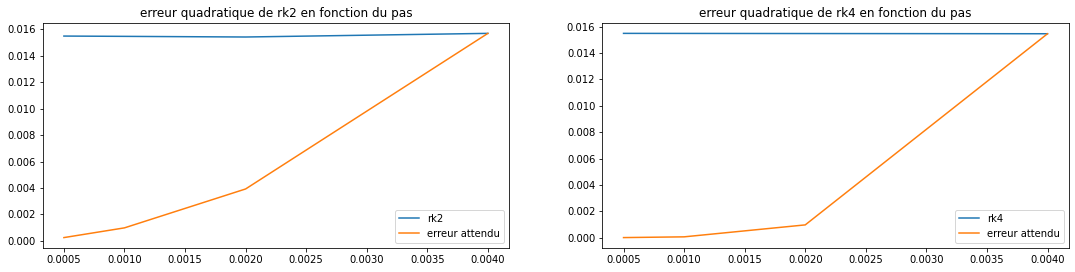

In [9]:
pas_list = 1/steps

plt.subplot(1, 2, 1)
plt.title("erreur quadratique de rk2 en fonction du pas")
plt.plot(1/steps, err_avg_rk2, label="rk2")

rk2_err_attendu = err_avg_rk2[0] * steps[0]**2 / steps**2
plt.plot(1/steps, rk2_err_attendu, label="erreur attendu")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("erreur quadratique de rk4 en fonction du pas")
plt.plot(pas_list, err_avg_rk4, label="rk4")

rk4_err_attendu = err_avg_rk4[0] * steps[0]**4 / steps**4
plt.plot(pas_list, rk4_err_attendu, label="erreur attendu")
plt.legend()

plt.subplots_adjust(left=0.125, right=2.5, bottom=0.1)
plt.show()

L'erreur de calcul est donc bien plus faible pour la methode rk4 que pour la methode rk2. On peut aussi remarquer que les erreur des methode rk2 et rk4 decroit bien moins vite qu'attendu.

### D - temps de calcul

On defini maintenant une fonction qui mesure le temps moyen d'execution d'une fonction sur 100 boucle.

In [10]:
def timeit(func, *args, **kwargs):
    t_avg = 0
    for _ in range(100):
        t_ref = time()
        func(*args, **kwargs)
        t_avg += (time() - t_ref) / 100
    return t_avg

On peut maintenant estimer les temps de claclul moyen pour chaque methode.

In [11]:
params = {
    "x0": 0,
    "x_point0": 0,
    "tau": 5,
    "w0": 1,
    "v0" : 0.3
}

t_list = np.linspace(0, 30, 1000)

t_rk2 = timeit(solution_complete, rk2, dxidt, t_list, params)
print(f"Le temps d'execution moyen de rk2 pour N=1000 est de t={round(t_rk2, 5)}s")

t_rk4 = timeit(solution_complete, rk4, dxidt, t_list, params)
print(f"Le temps d'execution moyen de rk4 pour N=1000 est de t={round(t_rk4, 5)}s")

t_solve_ivp = timeit(inte.solve_ivp, dxidt, (0, 30), np.array([0, 0]),
                     method='RK45', args=(params,), t_eval=t_list)
print(f"Le temps d'execution moyen de solv_ivp utilisant RK45 pour N=1000 est de t={round(t_solve_ivp, 5)}s")

Le temps d'execution moyen de rk2 pour N=1000 est de t=0.01464s
Le temps d'execution moyen de rk4 pour N=1000 est de t=0.03309s
Le temps d'execution moyen de solv_ivp utilisant RK45 pour N=1000 est de t=0.00498s


On peut voir que la methode RK4 utilisée par solve_inp est presque 10 fois plus rapide que notre methode naïve (sur mon ordinateur), qui est elle-meme 2 fois plus lente que la methode rk2 (ce qui semble coherent puisque tout les calcule sont en serie et que la methode rk2 appelle la fonction dxidt 2 fois moins souvent que rk4).

Cet ecart est probablement du à la capacité de numpy de distribuer certain calcul, et d'utiliser des langages compilés (comme le c ou fortran) pour certaine partie de l'algorithme (probablement pas celle qui utilse nos fonction puisqu'elle sont elle definie en utilisant l'interpreteur de python).

On peut maintenant tracer cette solution en x0=0 en utilisant solve_ivp et la solution analytique et tracer l'erreur quadratique entre les deux (on prendra 500 points).

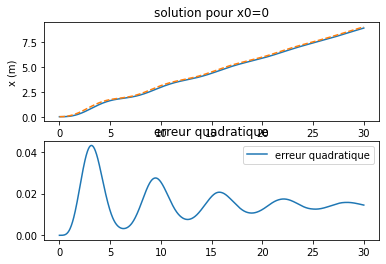

In [12]:
t_list = np.linspace(0, 30, 1000)

sol_solve_ivp = inte.solve_ivp(dxidt, (0, 30), np.array([0, 0]),
                     method='RK45', args=(params,), t_eval=t_list).y
sol_analytique = solution_analytique(t_list, params)

plt.subplot(2, 1, 1)
plt.title("solution pour x0=0")

plt.plot(t_list, sol_solve_ivp[0,:], label="solve_ivp(t)")
plt.plot(t_list, sol_analytique, "--", label="x(t)")

plt.xlabel("t (s)")
plt.ylabel("x (m)")

plt.subplot(2, 1, 2)
plt.title("erreur quadratique")

plt.plot(t_list, (sol_solve_ivp[0,:] - sol_analytique)**2, label="erreur quadratique")


plt.legend()
plt.show()

La solution en x0 = 0 ne semble pas representer la réalité des seismes car la masse ne connait très peut d'oscilations et rentre quasi-instantanement en translation uniforme à une vitesse v0.

## 5.2 Frottement statique

__A)__ Ce modele pose probleme lorsque x0 < 0 puisque f0 n'est pas pair. On pourait resoudre se probleme en definissant $ f_0'( \dot{x} ) = sign(\dot{x}) f_0(\left| \dot{x} \right| ) $.

Lorsque $\dot{x} \rightarrow 0$ on a $ \frac{f_0(\dot{x})}{m} \rightarrow \gamma$ ce qui voudrait dire que on a un frottement solide important meme quand $\dot{x}$ ralenti.

On a $\frac{f_0}{\dot{x}} = -\tau ^{-1} + \frac{\gamma}{v_f}exp\left(-\frac{\dot{x}}{v_f}\right)$, or quand $\dot{x} < v_f$ on a $exp\left(-\frac{\dot{x}}{v_f}\right) \rightarrow 1$ et donc on aura le frotement qui decroit si $\gamma > \frac{v_f}{\tau}$.

On definie d'abord la fonction f0 puis on la trace sur $ v \in \left[0 , 4 \right] $.

In [13]:
def f0_m(v, params):
    f0_norm = -abs(v)*params["tau"] - params["gamma"]*np.exp(-abs(v)/params["vf"])
    return f0_norm * np.sign(v)

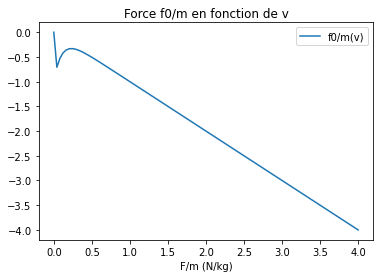

In [14]:
params = {
    "x0": 5,
    "x_point0": 0,
    "tau": 1,
    "w0": 1,
    "v0" : 0.3,
    "gamma": 1,
    "vf": 0.1,
}

v_list = np.linspace(0, 4, 100)

plt.plot(v_list, f0_m(v_list, params), label="f0/m(v)")

plt.xlabel("v (m/s)")
plt.xlabel("F/m (N/kg)")

plt.title("Force f0/m en fonction de v")
plt.legend()
plt.show()

__B)__ On trouve pour cette solution uniforme $ x_0 = - \left(\frac{v_0}{\tau} + \gamma \right) \omega_0 ^ {-2} $.

Soit u(t) = x(t) - x0, on trouve l'equation differentiel $\ddot{u} + \tau ^{-1}\dot{u}+ \gamma exp\left(-\frac{\dot{u}}{v_f} \right) + \omega_0^2 u = 0$.

Pour $\dot{u} << v_f $ on obtient l'equation differentiel approchée $\ddot{u} + \left(\tau ^{-1} - \frac{\gamma}{v_f} \right)  \dot{u} + \omega_0^2 u = - \gamma $.

Soit le coefficient devant $\dot{u} $ que l'on nomme $ \tau' = \left(\tau ^{-1} - \frac{\gamma}{v_f} \right) $, si $\tau' > 0$ on aurra une solution simillaire à celle trouvé precedement, c'est à dire des oscilation (ou pas) modulée par une exponentiel decroissante autour de la courbe $x(t) = x_0 + v_0 t$.

Au contraire si $\tau' < 0$ ces oscilations sont modulées par une exponetiel croissante et on a donc divergence de la solution. Physiquement cela correspondrait à une resonance.

__C)__ On peut maintenant definir les fonctions permettants de resoudre le problems numeriquement. 

In [15]:
def dxidt_fs(t, X, params):
    x, x_point = X[0], X[1]
    # On caclule la derivé du vecteur X
    x_point_point = -params["w0"]**2 * (x - params["v0"] * t) + f0_m(x_point, params)
    
    return np.array([x_point, x_point_point])

On trace maintenant la solution numerqiue pour des $\tau$ different.

In [ ]:
t_list = np.linspace(0, 30, 500)

sol_1tau = inte.solve_ivp(dxidt_fs, (0, 30), np.array([0, 0]),
                          method='RK45', args=(params,), t_eval=t_list).y

params["tau"] = 5

sol_5tau = inte.solve_ivp(dxidt_fs, (0, 30), np.array([0, 0]),
                          method='RK45', args=(params,), t_eval=t_list).y

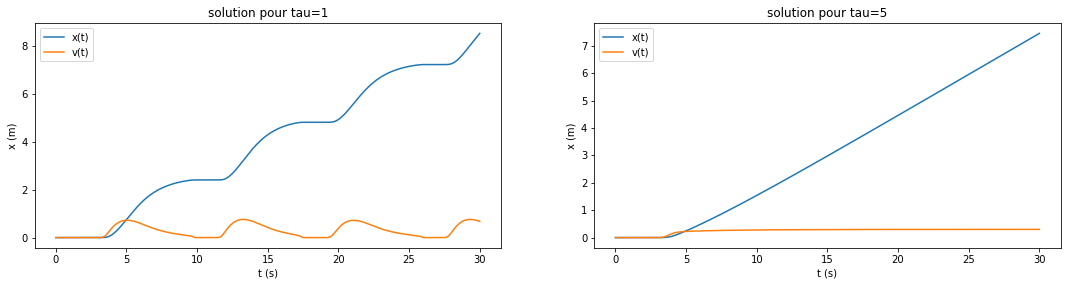

In [28]:
t_list = np.linspace(0, 30, 500)

plt.subplot(1, 2, 1)
plt.title("solution pour tau=1")
plt.plot(t_list, sol_1tau[0,:], label="x(t)")
plt.plot(t_list, sol_1tau[1,:], label="v(t)")
plt.xlabel("t (s)")
plt.ylabel("x (m)")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("solution pour tau=5")
plt.xlabel("t (s)")
plt.ylabel("x (m)")
plt.plot(t_list, sol_5tau[0,:], label="x(t)")
plt.plot(t_list, sol_5tau[1,:], label="v(t)")
plt.legend()

plt.subplots_adjust(left=0.125, right=2.5, bottom=0.1)
plt.show()

La solution pour $\tau = 1$ correspond à des oscilation autour de la solution particuliere, alors que pour $\tau = 5$ on a une "dechirure" brutale puis le patin se met à suivre la solution particuliere.

Dans ce second cas le patin ne bouge pas pour environ 4 secondes, puis il se met en mouvement à la vitesse $v_0$ qui vaut ici 0.3$ms^{-1}$.

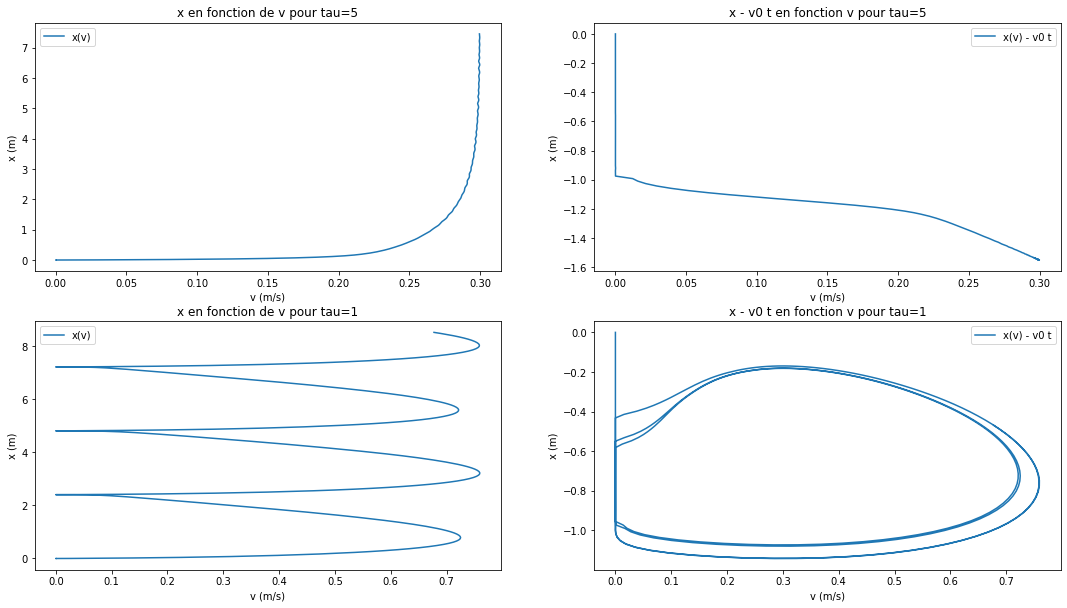

In [29]:
t_list = np.linspace(0, 30, 500)

plt.subplot(2, 2, 1)
plt.title("x en fonction de v pour tau=5")
plt.plot(sol_5tau[1,:], sol_5tau[0,:], label="x(v)")
plt.xlabel("v (m/s)")
plt.ylabel("x (m)")
plt.legend()

plt.subplot(2, 2, 2)
plt.title("x - v0 t en fonction v pour tau=5")
plt.plot(sol_5tau[1,:], sol_5tau[0,:] - params["v0"]*t_list, label="x(v) - v0 t")
plt.xlabel("v (m/s)")
plt.ylabel("x (m)")
plt.legend()

plt.subplot(2, 2, 3)
plt.title("x en fonction de v pour tau=1")
plt.plot(sol_1tau[1,:], sol_1tau[0,:], label="x(v)")
plt.xlabel("v (m/s)")
plt.ylabel("x (m)")
plt.legend()

plt.subplot(2, 2, 4)
plt.title("x - v0 t en fonction v pour tau=1")
plt.plot(sol_1tau[1,:], sol_1tau[0,:] - params["v0"]*t_list, label="x(v) - v0 t")
plt.xlabel("v (m/s)")
plt.ylabel("x (m)")
plt.legend()

plt.subplots_adjust(left=0.125, right=2.5, bottom=0.1, top = 2)
plt.show()

En tracant x - v0 t on peut observer les oscilation autour de la solution particuliere (cela revien à se mettre dans le referentiel de l'objet qui tire le ressort). Cela nous permet de voir la difference entre une solution qui oscile autour de l'equilibre et une solution (comme celle pour $\tau=5$) qui possede une "cassure" brutale.

__D)__ Pour etudier 4 patins on va ecrire une nouvelle fonction dxidt qui prend cette fois un vecteur de 8 elements (vitesse et position de chaque patin). On utilisera la fonction dxidt precedente, et l'on se mettra dans le referentiel du iem patins pour etudier le suivant.

In [21]:
def dxidt_4_patins(t, X, params):
    res = np.zeros(8)
    
    res[:2] = dxidt_fs(t, X[:2], params)
    for i in range(1, 4):
        res[2*i] = X[2*i + 1]
        res[2*i + 1] = f0_m(X[2*i + 1] - X[2*i - 1], params)
    
    return res

In [23]:
t_list = np.linspace(0, 30, 250)
x0 = np.array([0, 0, 1, 0, 2, 0, 3, 0])

sol_1tau_4_patins = inte.solve_ivp(dxidt_4_patins, (0, 30), x0,
                                   method='RK45', args=(params,), t_eval=t_list).y

params["tau"] = 5

sol_5tau_4_patins = inte.solve_ivp(dxidt_4_patins, (0, 30), x0,
                                   method='RK45', args=(params,), t_eval=t_list).y

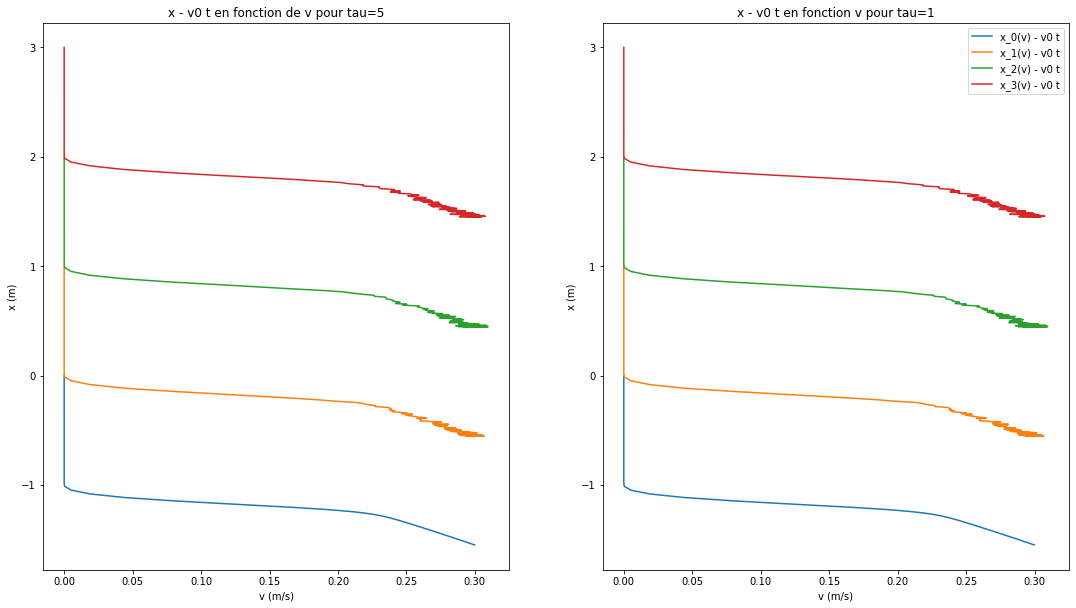

In [25]:
t_list = np.linspace(0, 30, 250)

plt.subplot(1, 2, 1)
plt.title("x - v0 t en fonction de v pour tau=5")
plt.xlabel("v (m/s)")
plt.ylabel("x (m)")
plt.legend()
for i in range(4):
    plt.plot(sol_5tau_4_patins[2*i + 1,:],
             sol_5tau_4_patins[2*i,:] - params["v0"]*t_list, label=f"x_{ i + 1 }(v) - v0 t")

plt.subplot(1, 2, 2)
plt.title("x - v0 t en fonction v pour tau=1")
plt.xlabel("v (m/s)")
plt.ylabel("x (m)")
plt.legend()
for i in range(4):
    plt.plot(sol_1tau_4_patins[2*i + 1,:],
             sol_1tau_4_patins[2*i,:] - params["v0"]*t_list, label=f"x_{ i + 1 }(v) - v0 t")

plt.subplots_adjust(left=0.125, right=2.5, bottom=0.1, top = 2)
plt.show()

On a dans les deux cas un fenomen de "cassure" pour chacun des patins.